In [1]:
data_dir ="/content/drive/MyDrive/Colab Notebooks/jena_climate_2009_2016.csv"

In [2]:
import numpy as np
import os
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values
print(float_data.shape)

(420451, 14)


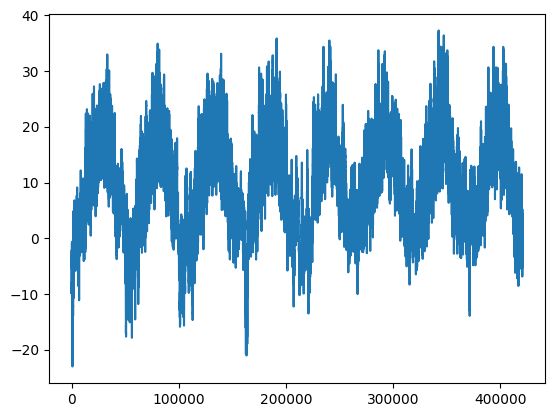

In [4]:
from matplotlib import pyplot as plt
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

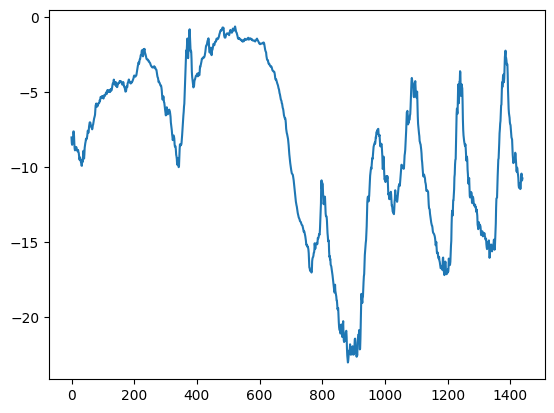

In [5]:
plt.plot(range(1440),temp[:1440])

In [6]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

In [7]:
# def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
#   if max_index is None:
#     max_index = len(data) - delay - 1
#   i = min_index + lookback
#   while 1:
#     if shuffle:
#       rows = np.random.randint(
#           min_index + lookback, max_index, size = batch_size)

#     else:
#       if i + batch_size >= max_index:
#         i = min_index + lookback
#       rows = np.arange(i, min(i + batch_size, max_index))
#       i += len(rows)
#     samples = np.zeros(len(rows), lookback//step, data.shape[-1])
#     targets = np.zeros((len(rows),))
#     for j, row in enumerate(rows):
#       indices = range(rows[j] - lookback, rows[j], step)
#       samples[j] = data[indices]
#       targets [j] = data[rows[j] + delay][1]
#     yield samples, targets

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)

        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)//batch_size
test_steps = (len(float_data) - 300001 - lookback)//batch_size

In [9]:
# def evaluate_naive_method():
#   batch_maes = []
#   for step in range(val_steps):
#     samples, targets = next(val_gen)
#     print(samples.shape)
#     print(targets.shape)
#     preds = samples[:,-1,1]
#     mae = np.mean(np.abs(preds-targets))
#     batch_maes.append(mae)
#   print(np.mean(batch_maes))
# evaluate_naive_method()
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print("Validation MAE:", np.mean(batch_maes))

evaluate_naive_method()

Validation MAE: 0.2897359729905486


In [10]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

In [11]:
model = Sequential()
model.add(LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [12]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


<ipython-input-12-4f77649be1a6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 23s 31ms/step - loss: 0.3050 - val_loss: 0.2683
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2714 - val_loss: 0.2750
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2600 - val_loss: 0.2680
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2508 - val_loss: 0.2773
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2445 - val_loss: 0.2798
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2359 - val_loss: 0.2869
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2291 - val_loss: 0.2894
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2233 - val_loss: 0.2977
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2165 - val_loss: 0.3035
Epoch 10/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2123 - val_los

In [13]:
mae = model.evaluate_generator(test_gen, steps=test_steps)
print("Test MAE:", mae)

<ipython-input-13-d159bb206be2>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  mae = model.evaluate_generator(test_gen, steps=test_steps)


Test MAE: 0.32729190587997437


In [16]:
# 从测试数据生成器中获取一批数据
samples, targets = next(test_gen)
predictions = model.predict(samples)

# 反标准化预测值，以获得实际温度值
predictions = predictions * std[1] + mean[1]

4/4 [==============================] - 0s 11ms/step


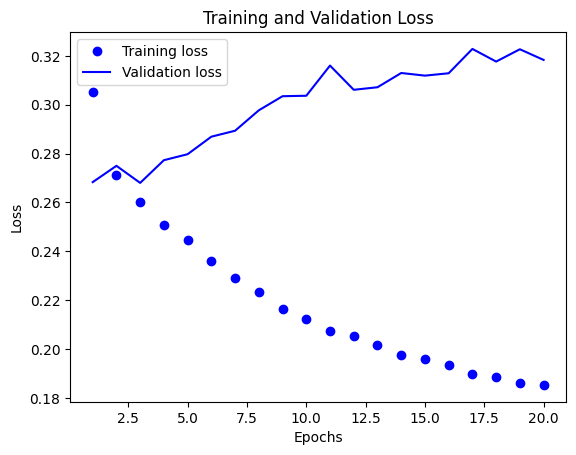

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

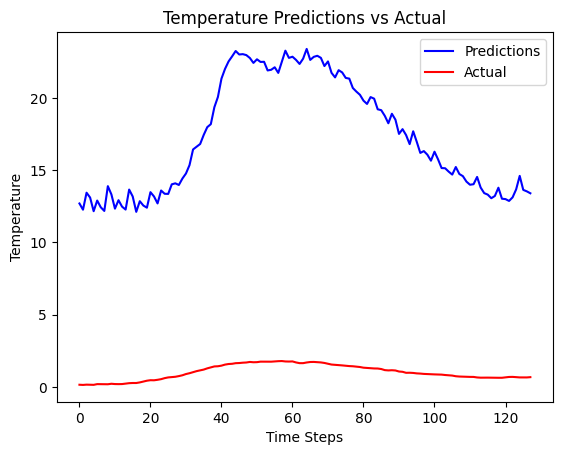

In [18]:
plt.figure()
plt.plot(range(len(predictions)), predictions, 'b', label='Predictions')
plt.plot(range(len(targets)), targets, 'r', label='Actual')
plt.title('Temperature Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()